In [1]:
import itertools

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob2 as glob
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import validators
import xarray as xr
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from erddapy import ERDDAP
from siphon.catalog import TDSCatalog

# Specify time and spatial ranges

In [2]:
# Specify start and end dates
start_date = np.datetime64("2024-01-01")
end_date = np.datetime64("2024-12-08")

# Define grids for map
# box = [lon_1,lon_2,lat_1,lat_2]
box = [161, 190, -52, -31]
# Grid cell resolution in degrees lon/lat
res = 1

# Calculate grid edges
x_edges = np.arange(box[0] - res, box[1] + res, res)
y_edges = np.arange(box[2] - res, box[3] + res, res)

# Methods

In [ ]:
def calc_grid_hist(
    x_coords: np.array, y_coords: np.array, time: np.array, x_edges: list, y_edges: list
) -> tuple[list, list, list]:
    """Takes x,y (e.g., lon, lat) coordinates of each profile or
    sensor deployment and calculates the average monthly number
    of profiles/deployments per grid cell.  Grid cells are defined
    by x_edges and y_edges (e.g., longitude and latitude coordinates).

    Parameters
    ----------
    x_coords : np.array
        Measurements' x_coordinates (e.g., longitude)
    y_coords : np.array
        Measurements' y_coordinates (e.g., latitude)
    time : np.array
        Measurements' times
    x_edges : list
        x-coordinates of grid cell edges
    y_edges : list
        y-coordinates of grid cell edges

    Returns
    -------
    tuple[list, list, list]
        Returns average monthly counts per grid cell (h) and grid
        cell centers (x,y), i.e. (lon,lat)
    """
    df = (
        pd.DataFrame(
            data={"xc": x_coords, "yc": y_coords, "time": pd.to_datetime(time)}
        )
        .drop_duplicates()
        .set_index("time")
    )

    x2 = []
    y2 = []
    h2 = []

    for xa, ya in itertools.product(x_edges, y_edges):
        yb = ya + res
        xb = xa + res
        in_cell = df.loc[
            (df.yc >= ya) & (df.yc < yb) & (df.xc >= xa) & (df.xc < xb)
        ].dropna()
        ctm = in_cell.resample("MS")["yc"].count().fillna(0).mean()
        x2.append((xa + xb) / 2)
        y2.append((ya + yb) / 2)
        h2.append(ctm)

    x = np.array(x2)
    y = np.array(y2)
    h = np.array(h2)

    return h, x, y

In [ ]:
def download_erddap(
    url: str,
    dataset_id: str,
    start_time: str,
    end_time: str,
    lon_min: float,
    lon_max: float,
    lat_min: float,
    lat_max: float,
    variables: list,
) -> pd.DataFrame:
    """Connects to ERDDAP, loads geospatial data into a pandas dataframe with
    time as the index.  Note that often you may need to query across a longitude
    of -180 using two separate queries using different lon_min and lon_max.

    Parameters
    ----------
    url : str
        ERDDAP url, for example, "http://www.ifremer.fr/erddap"
    dataset_id : str
        Comes from the particular ERDDAP server's documentation/metadata
    start_time : str
        Start of time range for query in format '%Y-%m-%dT%H:%M:%S'
    end_time : str
        End of time range for query in format '%Y-%m-%dT%H:%M:%S'
    lon_min : float
    lon_max : float
    lat_min : float
    lat_max : float
    variables : list
        Variables to return from ERDDAP query, example, ['latitude','longitude',
        'time','instrument_serial_number','depth','temp','qc_flag']

    Returns
    -------
    pd.DataFrame
        Pandas dataframe containing the variables in variable_list as columns and with time as the index
    """
    e = ERDDAP(server=url, protocol="tabledap")
    e.response = "nc"
    e.dataset_id = dataset_id
    e.variables = variables

    e.constraints = {
        "latitude>=": lat_min,
        "latitude<=": lat_max,
        "longitude>=": lon_min,
        "longitude<=": lon_max,
        "time>=": start_time,
        "time<=": end_time,
    }
    df = e.to_pandas(parse_dates=["time (UTC)"], index_col="time (UTC)").dropna()

    return df

In [ ]:
def load_argo(
    url: str = "http://www.ifremer.fr/erddap",
    dataset_id: str = "ArgoFloats",
    start_date: np.datetime64 = start_date,
    end_date: np.datetime64 = end_date,
    box=box,
    variables: list = ["latitude", "longitude", "time", "float_serial_no", "pres"],
) -> pd.DataFrame:

    dmin = pd.to_datetime(start_date).strftime("%Y-%m-%dT%H:%M:%S")
    dmax = pd.to_datetime(end_date).strftime("%Y-%m-%dT%H:%M:%S")

    # Reformat "box" for use with ERDDAP, i.e. break into
    # two boxes on either side of the international dateline
    # if needed.

    if box[1] > 180:
        box1 = list(box)
        box2 = list(box)
        box1[1] = 180
        box2[0] = -180
        box2[1] = (box[1] + 180) % 360 - 180
    else:
        box1 = box
        box2 = False

    # one side of the international date line
    argo = download_erddap(
        url,
        dataset_id,
        start_time=dmin,
        end_time=dmax,
        lon_min=box1[0],
        lon_max=box1[1],
        lat_min=box1[2],
        lat_max=box1[3],
        variables=variables,
    )

    # other side of the international date line, if needed
    if box2:
        argo_1 = download_erddap(
            url,
            dataset_id,
            start_time=dmin,
            end_time=dmax,
            lon_min=box2[0],
            lon_max=box2[1],
            lat_min=box2[2],
            lat_max=box2[3],
            variables=variables,
        )

        # put the two sides of the international date line together
        argo = pd.concat([argo, argo_1])
        argo = argo.rename(
            columns={
                "latitude (degrees_north)": "lat",
                "longitude (degrees_east)": "lon",
            }
        )

        # convert longitude to 0-360
        argo["lon"] = argo["lon"] % 360

    return argo

In [ ]:
def load_moana(
    source: str = "http://thredds.moanaproject.org:6443/thredds/catalog/moana/Mangopare/public/catalog.html",
    start_date: np.datetime64 = start_date,
    end_date: np.datetime64 = end_date,
) -> tuple[pd.DataFrame, dict, list]:
    """Loads public Mangōpare data from the Moana Project THREDDS server,
    or local directory, between start_date and end_date.  Calculates statistics
    including the number of measurements, max depth, and duration of each
    deployment.

    Parameters
    ----------
    source : str, optional
        THREDDS server url, by default "http://thredds.moanaproject.org:6443/thredds/catalog/moana/Mangopare/public/catalog.html"
        or directory to find files in, e.g., '/path_to_files/*.nc'
    start_date : np.datetime64, optional
        Start of desired date range, by default start_date
    end_date : np.datetime64, optional
        End of desired date range, by default end_date

    Returns
    -------
    tuple[pd.DataFrame, dict, list]
        Returns a dataframe of the initial latitude, longitude,
        and time of each deployment, a dictionary of the above statistics,
        and an array of the time of all measurements.
    """
    if validators.url(source):
        # load THREDDS catalog
        cat = TDSCatalog(source)
        filelist = sorted(cat.datasets)
    else:
        filelist = glob.glob(source)

    # initialise variables

    lat = []
    lon = []
    time = []
    deploy_time = []

    num_measurements = []
    max_depths = []
    durations = []

    for file in filelist:

        sdn = pd.to_datetime(file[6:14], format="%Y%m%d").to_numpy()
        if (sdn < start_date) or (sdn > end_date):
            continue
        if validators.url(source):
            ds = cat.datasets[file].remote_access(use_xarray=True)
        else:
            ds = xr.open_dataset(file)

        mask = ds["QC_FLAG"] < 4
        ds = ds.where(mask, drop=True)
        ds = ds.where(ds["TIME"] >= start_date, drop=True)
        ds = ds.where(ds["TIME"] <= end_date, drop=True)

        if len(ds.LATITUDE) < 1:
            ds.close()
            continue

        lat.append(float(ds.LATITUDE[0]))
        lon.append(float(ds.LONGITUDE[0]))
        deploy_time.append(ds.TIME[0].values)
        time.extend(ds.TIME.values)

        num_measurements.append(len(ds.TIME.values))
        max_depths.append(np.nanmax(ds.DEPTH.values))
        durations.append(np.nanmax(ds.TIME) - np.nanmin(ds.TIME))

        ds.close()

    moana_df = pd.DataFrame({"lat": lat, "lon": lon, "time": deploy_time}).dropna()
    moana_df["time"] = moana_df["time"].dt.tz_localize("UTC")

    stats_moana = {
        "num_measurements": num_measurements,
        "max_depths": max_depths,
        "durations": durations,
    }

    return moana_df, stats_moana, time

In [39]:
def load_moana_db(
    source: str = "sqlite:///moana.db",
    start_date: np.datetime64 = start_date,
    end_date: np.datetime64 = end_date,
    qc_flag_max: int = 3,
) -> tuple[pd.DataFrame, dict, list]:
    """Loads public Mangōpare data from the Moana Project THREDDS server,
    or local directory, between start_date and end_date.  Calculates statistics
    including the number of measurements, max depth, and duration of each
    deployment.

    Parameters
    ----------
    source : str, optional
        database file, by default "moana.db"
    start_date : np.datetime64, optional
        Start of desired date range, by default start_date
    end_date : np.datetime64, optional
        End of desired date range, by default end_date

    Returns
    -------
    tuple[pd.DataFrame, dict, list]
        Returns a dataframe of the initial latitude, longitude,
        and time of each deployment, a dictionary of the above statistics,
        and an array of the time of all measurements.
    """

    import sqlite3
    from sqlalchemy.engine import create_engine
    from sqlalchemy.engine.base import Engine

    disk_engine = create_engine(source)

    moana_df = pd.read_sql_query(
        "SELECT MIN(time) as time, AVG(lat) as lat, AVG(lon) as lon FROM observations WHERE qcflag<"
        + str(qc_flag_max)
        + " GROUP BY file",
        disk_engine,
    )

    time = pd.read_sql_query(
        "SELECT time FROM observations WHERE qcflag<" + str(qc_flag_max), disk_engine
    )

    # calculate number of measurements, maximum depth, and duration in hours of each deployment (or more accurately, file)
    stats_moana = pd.read_sql_query(
        "SELECT COUNT(*) as num_measurements, MAX(depth) as max_depth, CAST ((julianday(MAX(time),'utc')-julianday(MIN(time),'utc')) * 24 AS Float) as durations FROM observations WHERE qcflag<"
        + str(qc_flag_max)
        + " GROUP BY file",
        disk_engine,
    )

    moana_df["time"] = moana_df['time']=pd.to_datetime(moana_df['time'], format='%Y-%m-%d %H:%M:%S.000000', errors='coerce').dropna().dt.tz_localize("UTC")

    stats_moana = stats_moana.to_dict(orient="list")

    return moana_df, stats_moana, time

In [ ]:
def set_plot_params(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_color("#DDDDDD")

    # Second, remove the ticks as well.
    ax.tick_params(bottom=False, left=False, right=False)

    # Third, add a horizontal grid (but keep the vertical grid hidden).
    # Color the lines a light gray as well.
    ax.set_axisbelow(True)

    ax.yaxis.grid(True, color="#EEEEEE")
    ax.xaxis.grid(False)

# Load and process Argo data

In [41]:
argo = load_argo()

argo_h, argo_x, argo_y = calc_grid_hist(
    x_coords=argo["lon"].values,
    y_coords=argo["lat"].values,
    time=argo.index,
    x_edges=x_edges,
    y_edges=y_edges,
)

/Users/jkat/miniconda3/envs/plots_env/lib/python3.12/site-packages/erddapy/core/interfaces.py:39: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(data, **(pandas_kwargs or {}))
/Users/jkat/miniconda3/envs/plots_env/lib/python3.12/site-packages/erddapy/core/interfaces.py:39: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(data, **(pandas_kwargs or {}))


# Load and process Mangōpare/Moana data

In [44]:
# load moana data from THREDDS or other directory
# moana, stats_moana, time = load_moana()
# load moana from sqlite database
moana, stats_moana, time = load_moana_db(
    source="sqlite:////Users/jkat/source/moana_db/moana.db"
)

moana_h, moana_x, moana_y = calc_grid_hist(
    x_coords=moana["lon"].values,
    y_coords=moana["lat"].values,
    time=moana["time"].values,
    x_edges=x_edges,
    y_edges=y_edges,
)

# Map of horizontal geospatial coverage

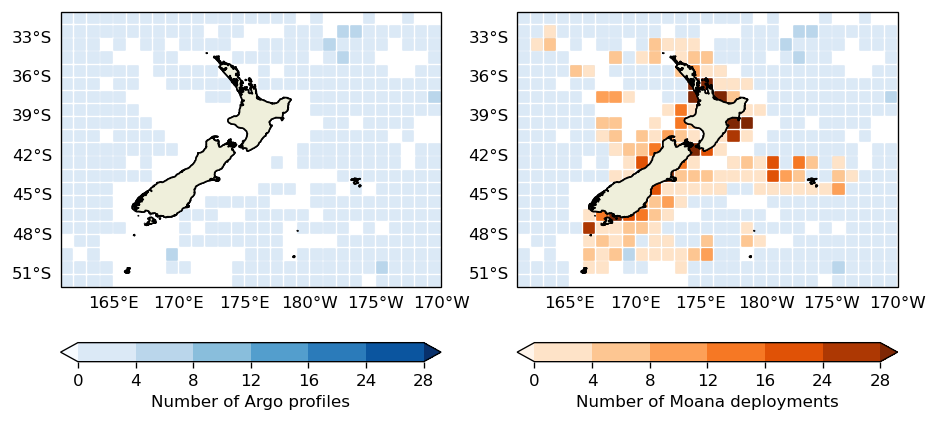

In [45]:
# plot parameters
ms = 38
bounds = [0, 4, 8, 12, 16, 24, 28]

plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

lon_offset = 180

# Set up plots
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,
                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=lon_offset)},
                               figsize=(9, 6), dpi=120, facecolor='w', edgecolor='k')

## Panel 1

# plot Argo data

colors = plt.get_cmap('Blues')(np.linspace(0, 1, len(bounds) + 1))
cmap = mcolors.ListedColormap(colors[1:-1])
cmap.set_over(colors[-1])
cmap.set_under(colors[0])
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds) - 1)
sc2 = ax0.scatter(argo_x + lon_offset, argo_y, c=argo_h, s=ms, marker='s', cmap=cmap, norm=norm)

ax0.plot([box[0], box[0], box[1], box[1]], [box[2], box[3], box[3], box[2]])

cb = plt.colorbar(sc2, ax=ax0, extend='both', orientation='horizontal', pad=0.1)
cb.set_label('Number of Argo profiles')

# plot properties
ax0.set_extent(box, crs=ccrs.PlateCarree())
ax0.coastlines(resolution='10m', facecolor='grey')
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='black', facecolor=cfeature.COLORS['land'])
ax0.add_feature(land_10m)

gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                   linewidth=0, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(range(-180, 180, 5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.xlabel_style = {'color': 'black'}

## Panel 2

# plot Argo data

colors = plt.get_cmap("Blues")(np.linspace(0, 1, len(bounds) + 1))
cmap = mcolors.ListedColormap(colors[1:-1])
cmap.set_over(colors[-1])
cmap.set_under(colors[0])
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds) - 1)
sc2 = ax1.scatter(
    argo_x + lon_offset, argo_y, c=argo_h, s=ms, marker="s", cmap=cmap, norm=norm
)

# plot Mangopare data
colors = plt.get_cmap("Oranges")(np.linspace(0, 1, len(bounds) + 1))
cmap = mcolors.ListedColormap(colors[1:-1])
cmap.set_over(colors[-1])
cmap.set_under(colors[0])
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds) - 1)
sc = ax1.scatter(moana_x + lon_offset, moana_y, c=moana_h, s=ms, marker="s", cmap=cmap, norm=norm)

ax1.plot([box[0], box[0], box[1], box[1]], [box[2], box[3], box[3], box[2]])

# Colorbars
cb = plt.colorbar(sc, ax=ax1, extend="both", orientation="horizontal", pad=0.1)
cb.set_label(r"Number of Moana deployments")

# plot properties
ax1.set_extent(box, crs=ccrs.PlateCarree())
ax1.coastlines(resolution="10m", facecolor="grey")
land_10m = cfeature.NaturalEarthFeature(
    "physical", "land", "10m", edgecolor="black", facecolor=cfeature.COLORS["land"]
)
ax1.add_feature(land_10m)

gl = ax1.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0,
    color="gray",
    alpha=0.5,
    linestyle="--",
)
gl.top_labels = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator(range(-180, 180, 5))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {"size": 15, "color": "black"}
gl.xlabel_style = {"color": "black"}

# fig.text(0.5, 0.83, r'Average Argo Events and Mang$\mathrm{\bar{o}}$pare Deployments:'+' {} through {}'.format(datemin,datemax,len(locs['lat'])),ha='center')
# fig.text(0.5, 0.83, r'Monthly Average Argo Profiles and Sensor Deployments:'+' {} through {}'.format(datemin,datemax,len(locs['lat'])),ha='center')

plt.show()

# Create bar plot of number of deployments/profiles over time

/var/folders/x3/2vkg00ln6rd9yvrqz14ky4xh0000gn/T/ipykernel_64207/182598920.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  moana.groupby(pd.Grouper(key="time", freq="M")).size(),
/var/folders/x3/2vkg00ln6rd9yvrqz14ky4xh0000gn/T/ipykernel_64207/182598920.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dft_argo.groupby(pd.Grouper(key="time", freq="M")).size(),


Text(0.5, 0, 'Date [mmm-yy]')

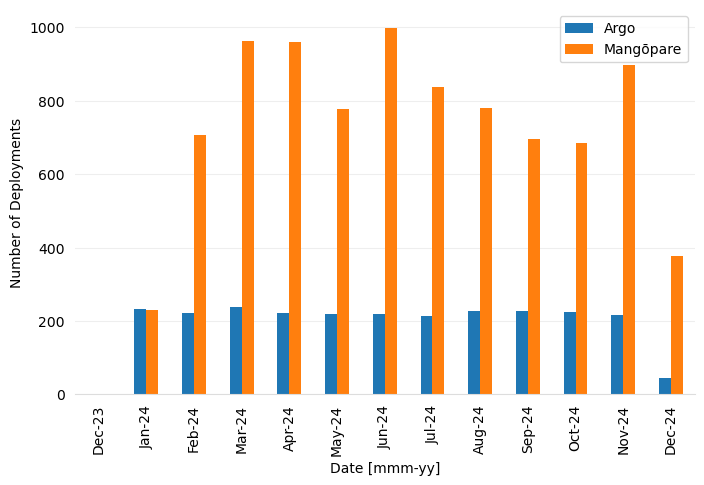

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

dft_argo = (
    argo.drop(columns="pres (decibar)")
    .drop_duplicates()
    .reset_index()
    .rename(columns={"time (UTC)": "time"})
)

df_comb = pd.concat(
    [
        moana.groupby(pd.Grouper(key="time", freq="M")).size(),
        dft_argo.groupby(pd.Grouper(key="time", freq="M")).size(),
    ],
    axis=1,
).reset_index()
df_comb = df_comb.rename(columns={0: "Mangōpare", 1: "Argo"}).set_index("time")
df_comb = df_comb[["Argo", "Mangōpare"]]

df_comb.plot.bar(ax=ax)

set_plot_params(ax)
x_dates = [vals.strftime("%b-%y") for vals in df_comb.index]
ax.set_xticklabels(labels=x_dates, rotation=90, ha="center")
ax.set_ylabel("Number of Deployments")
ax.set_xlabel("Date [mmm-yy]")